In [1]:
# Common import 
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Settings And Const

COMMENT_PATTERN_FOR_ORDERS_ONLY = "[tp]"
COMMENT_PATTERN_FOR_START_ORDERS = 'Start'
COMMENT_PATTERN_FOR_SELL_ORDERS = 'SELL'
COMMENT_PATTERN_FOR_BUY_ORDERS = 'BUY'

OPEN_NEW_ORDER_PRICE_DELTA_PIPS = 180 # Eve average position when price goes more then 180 pips
XAU_PIP_USD = 0.01 # 1 pip = 0.01 for XAU

QTY_FACTOR_FOR_AVERAGE = 1.65 #todo Must use table
EVE_MAX_ORDER_COUNT = 20

COLUMNS_MAPPING={
    'Deal': 'ORDER_ID', 
    'Open time': 'OPEN_DT', 
    'Type': 'SIDE', 
    'Size': 'QTY', 
    'Item': 'SYMBOL', 
    'Price': 'OPEN_PRICE', 
    'S/L': 'STOP_LOSS', 
    'T/P': 'TAKE_PROFIT',
    'Time': 'CLOSE_DT', 
    'Close': 'CLOSE_PRICE', 
    'Commission': 'FEE', 
    'Swap': 'SWAP', 
    'Profit': 'PROFIT', 
    'Comment': 'COMMENT'
}

In [3]:
# Data import
df_origin = pd.read_excel('report.xls')
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828 entries, 0 to 827
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Deal        828 non-null    int64  
 1   Open time   828 non-null    object 
 2   Type        828 non-null    object 
 3   Size        828 non-null    float64
 4   Item        814 non-null    object 
 5   Price       828 non-null    float64
 6   S/L         828 non-null    int64  
 7   T/P         828 non-null    float64
 8   Time        828 non-null    object 
 9   Close       828 non-null    float64
 10  Commission  828 non-null    int64  
 11  Swap        828 non-null    float64
 12  Profit      828 non-null    float64
 13  Comment     828 non-null    object 
dtypes: float64(6), int64(3), object(5)
memory usage: 90.7+ KB


In [4]:
# Dataset preparation
# Rename columns, type casting and USDC transformation

def prepare_columns(df: pd.DataFrame) -> pd.DataFrame:
    ''' 
    Renames columns using COLUMNS_MAPPING.
    Check all columns in df after, overwise call Exception/.
    '''
    df_res = df.copy()
    df_res = df_res.rename(columns=COLUMNS_MAPPING)
    if not all([c in df_res.columns for c in COLUMNS_MAPPING.values()]):
        raise Exception("There're not all columns from COLUMNS_MAPPING in data frame")
        
    # Datetime casting
    df_res['OPEN_DT'] = pd.to_datetime(df_res['OPEN_DT'])
    df_res['CLOSE_DT'] = pd.to_datetime(df_res['CLOSE_DT'])

    # Convert USDC to USD
    df_res['PROFIT'] = df_res['PROFIT'] / 100

    # Add columns
    df_res['DK_OPEN_VALUE'] = df_res['OPEN_PRICE'] * df_res['QTY'] 
    df_res['DK_BALANCE_OUT'] = df_res['PROFIT'].cumsum()
    df_res['DK_BALANCE_IN'] = df_res['DK_BALANCE_OUT'] - df_res['PROFIT']
    
    return df_res

df = prepare_columns(df_origin)
df

,ORDER_ID,OPEN_DT,SIDE,QTY,SYMBOL,OPEN_PRICE,STOP_LOSS,TAKE_PROFIT,CLOSE_DT,CLOSE_PRICE,FEE,SWAP,PROFIT,COMMENT,DK_OPEN_VALUE,DK_BALANCE_OUT,DK_BALANCE_IN
0,69906476,2023-05-26 15:28:10,balance,0.00,NaN,0.00,0,0.00,2023-05-26 15:28:10,0.00,0,0.0,99.0000,Deposit CCTT 21364338,0.0000,99.0000,0.0000
1,69912876,2023-05-26 15:36:59,balance,0.00,NaN,0.00,0,0.00,2023-05-26 15:36:59,0.00,0,0.0,1974.0619,Deposit CCTT 21364558,0.0000,2073.0619,99.0000
2,69939230,2023-05-26 17:10:33,sell,0.03,XAUUSD,1950.73,0,1949.23,2023-05-26 17:20:48,1949.20,0,0.0,0.0459,Start SELL[tp],58.5219,2073.1078,2073.0619
3,69940374,2023-05-26 17:21:00,buy,0.03,XAUUSD,1949.23,0,1950.73,2023-05-26 17:27:21,1950.75,0,0.0,0.0456,Start BUY[tp],58.4769,2073.1534,2073.1078
4,69940734,2023-05-26 17:28:00,sell,0.03,XAUUSD,1950.20,0,1948.70,2023-05-26 17:29:24,1948.64,0,0.0,0.0468,Start SELL[tp],58.5060,2073.2002,2073.1534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,72850711,2023-06-16 05:48:02,sell,0.20,XAUUSD,1955.77,0,1955.22,2023-06-16 07:49:01,1955.21,0,0.0,0.1120,Start SELL[tp],391.1540,13004.1714,13004.0594
824,72854685,2023-06-16 06:29:01,sell,0.22,XAUUSD,1957.59,0,1955.22,2023-06-16 07:49:01,1955.21,0,0.0,0.5236,SELL 2[tp],430.6698,13004.6950,13004.1714
825,72868535,2023-06-16 09:08:01,buy,0.20,XAUUSD,1959.99,0,1961.49,2023-06-16 09:21:38,1961.50,0,0.0,0.3020,Start BUY[tp],391.9980,13004.9970,13004.6950
826,72872812,2023-06-16 09:22:01,buy,0.20,XAUUSD,1961.82,0,1962.30,2023-06-16 10:44:25,1962.34,0,0.0,0.1040,Start BUY[tp],392.3640,13005.1010,13004.9970


In [5]:
# Net Recognize Different Ways

def set_grid_id_by_one_side_start(df: pd.DataFrame, grid_id_col_name: str) -> pd.DataFrame:
    '''
        Set GRID_ID for all orders in df.
        New GRID_ID generates when order has "Start" mark inside COMMENT. 
        And it applies for all next orders of the same side until new "Start" mark comes.

        It's BEST method for one side grids.
    '''

    df_res = df.copy()

    net_id_sell, net_id_buy = None, None
    net_id_list = []
    for i, row in df_res.iterrows():
        if COMMENT_PATTERN_FOR_START_ORDERS in row['COMMENT']:
            if COMMENT_PATTERN_FOR_SELL_ORDERS in row['COMMENT']:
                net_id_sell = row['ORDER_ID']
            if COMMENT_PATTERN_FOR_BUY_ORDERS in row['COMMENT']:
                net_id_buy = row['ORDER_ID']

        if COMMENT_PATTERN_FOR_SELL_ORDERS in row['COMMENT']:
            net_id_list.append(net_id_sell if net_id_sell is not None else row['ORDER_ID']) 
        if COMMENT_PATTERN_FOR_BUY_ORDERS in row['COMMENT']:
            net_id_list.append(net_id_buy if net_id_buy is not None else row['ORDER_ID']) 
        
    df_res[grid_id_col_name] = net_id_list

    return df_res

def set_grid_id_by_timeline_emulating(df: pd.DataFrame, grid_id_col_name: str) -> pd.DataFrame:
    '''
        Set GRID_ID for all orders in df.
        Def emulates timeline using OPEN_DT and CLOSE_DT each order.
        New GRID_ID generates then first order opens. 
        It applies for all next orders until net has at least 1 order.
        When net becomes empty new GRID_ID will be generate.

        Pros: Usually one side grid closes when opposite side is still open. And this situation repeats often.
              So grids become huge - more than 20 orders.
              I guess that grid is order with same side.
              But grids with different sides can be opened at one time.
              So why this method is no good.
    '''    

    df_res = df.copy()
    df_timeline = pd.DataFrame(columns=['ORDER_ID', 'DT', 'EVENT']) # Event 0-open, 1-close

    # Place orders at open and close timeline
    for order_id, open_dt, close_dt in zip(df_res['ORDER_ID'], df_res['OPEN_DT'], df_res['CLOSE_DT']):
        event = {'ORDER_ID': order_id, 'DT': open_dt, 'EVENT': 0}
        df_timeline.loc[len(df_timeline)] = event

        event = {'ORDER_ID': order_id, 'DT': close_dt, 'EVENT': 1}
        df_timeline.loc[len(df_timeline)] = event

    df_timeline = df_timeline.sort_values(['DT', 'EVENT'], ascending=True)

    # Emulates opening and closing deal in net
    grid_curr = []
    grid_full = []
    grid_id = None
    for i, row in df_timeline.iterrows():
        if len(grid_curr) == 0:
            if grid_id is not None:
                df_res.loc[df_res['ORDER_ID'].isin(grid_full), [grid_id_col_name]] = grid_id
                grid_full = []

            grid_id = row['ORDER_ID']

        if row['EVENT'] == 0:
            grid_curr.append(row['ORDER_ID'])
            grid_full.append(row['ORDER_ID'])
        else:
            grid_curr = list(filter(lambda i: i == row['ORDER_ID'], grid_curr))

    return df_res

In [6]:
# Filter only orders deals without deposits and withdrawals
df_o = df[df['COMMENT'].str.contains(COMMENT_PATTERN_FOR_ORDERS_ONLY, regex=False)]
df_o = df_o.sort_values(by=['OPEN_DT', 'ORDER_ID'], ascending=True)

def set_cum_of_grids(df: pd.DataFrame, group_by_col: str, col_for_cum: str, res_col_name: str) -> pd.DataFrame:
    df_res = df.copy()
    df_res[res_col_name] = df_res.groupby(group_by_col)[col_for_cum].transform(pd.Series.cumsum)
    return df_res

df_o = set_grid_id_by_one_side_start(df_o, 'DK_GRID_ID')
df_o = set_cum_of_grids(df_o, 'DK_GRID_ID', 'QTY', 'DK_GRID_QTY')
df_o = set_cum_of_grids(df_o, 'DK_GRID_ID', 'DK_OPEN_VALUE', 'DK_GRID_VALUE')
df_o


,ORDER_ID,OPEN_DT,SIDE,QTY,SYMBOL,OPEN_PRICE,STOP_LOSS,TAKE_PROFIT,CLOSE_DT,CLOSE_PRICE,FEE,SWAP,PROFIT,COMMENT,DK_OPEN_VALUE,DK_BALANCE_OUT,DK_BALANCE_IN,DK_GRID_ID,DK_GRID_QTY,DK_GRID_VALUE
2,69939230,2023-05-26 17:10:33,sell,0.03,XAUUSD,1950.73,0,1949.23,2023-05-26 17:20:48,1949.20,0,0.0,0.0459,Start SELL[tp],58.5219,2073.1078,2073.0619,69939230,0.03,58.5219
3,69940374,2023-05-26 17:21:00,buy,0.03,XAUUSD,1949.23,0,1950.73,2023-05-26 17:27:21,1950.75,0,0.0,0.0456,Start BUY[tp],58.4769,2073.1534,2073.1078,69940374,0.03,58.4769
4,69940734,2023-05-26 17:28:00,sell,0.03,XAUUSD,1950.20,0,1948.70,2023-05-26 17:29:24,1948.64,0,0.0,0.0468,Start SELL[tp],58.5060,2073.2002,2073.1534,69940734,0.03,58.5060
5,69941173,2023-05-26 17:30:00,buy,0.03,XAUUSD,1948.20,0,1944.09,2023-05-26 19:01:11,1944.21,0,0.0,-0.1197,Start BUY[tp],58.4460,2073.0805,2073.2002,69941173,0.03,58.4460
6,69942587,2023-05-26 17:33:00,buy,0.03,XAUUSD,1945.79,0,1944.09,2023-05-26 19:01:11,1944.21,0,0.0,-0.0474,BUY 2[tp],58.3737,2073.0331,2073.0805,69941173,0.06,116.8197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
823,72850711,2023-06-16 05:48:02,sell,0.20,XAUUSD,1955.77,0,1955.22,2023-06-16 07:49:01,1955.21,0,0.0,0.1120,Start SELL[tp],391.1540,13004.1714,13004.0594,72850711,0.20,391.1540
824,72854685,2023-06-16 06:29:01,sell,0.22,XAUUSD,1957.59,0,1955.22,2023-06-16 07:49:01,1955.21,0,0.0,0.5236,SELL 2[tp],430.6698,13004.6950,13004.1714,72850711,0.42,821.8238
825,72868535,2023-06-16 09:08:01,buy,0.20,XAUUSD,1959.99,0,1961.49,2023-06-16 09:21:38,1961.50,0,0.0,0.3020,Start BUY[tp],391.9980,13004.9970,13004.6950,72868535,0.20,391.9980
826,72872812,2023-06-16 09:22:01,buy,0.20,XAUUSD,1961.82,0,1962.30,2023-06-16 10:44:25,1962.34,0,0.0,0.1040,Start BUY[tp],392.3640,13005.1010,13004.9970,72872812,0.20,392.3640


In [23]:
def set_worst_grid_price(df: pd.DataFrame, new_col_name: str) -> pd.DataFrame:
    '''
        Set for every order his worst price.
        Worst price is price lower then 1 pips of OPEN_NEW_ORDER_PRICE_DELTA_PIPS.
        If it was equal OPEN_NEW_ORDER_PRICE_DELTA_PIPS EVE took an new order.
    '''
    df_res = df.copy()

    df_res = df_res.sort_values(by=['DK_GRID_ID', 'ORDER_ID'], ascending=False)
    worst_price_list = []
    net_id_prev = None
    open_price_prev = None
    for (net_id, open_price, side) in zip(df_res['DK_GRID_ID'], df_res['OPEN_PRICE'], df_res['SIDE']):
        if net_id == net_id_prev:
            worst_price_list.append(open_price_prev)
        else:
            max_price_delta = (OPEN_NEW_ORDER_PRICE_DELTA_PIPS - 1) * XAU_PIP_USD
            if side == 'buy': 
                max_price_delta = -1 * max_price_delta
            worst_price_list.append(open_price + max_price_delta)

        open_price_prev = open_price
        net_id_prev = net_id

    df_res[new_col_name] = worst_price_list
    return df_res

df_o = set_worst_grid_price(df_o, 'DK_WORST_PRICE')

df_o['DK_DRAWDOWN'] = abs(df_o['DK_GRID_QTY'] * (df_o['DK_WORST_PRICE']) - df_o['DK_GRID_VALUE']) 
df_o['DK_DRAWDOWN_RATIO'] = df_o['DK_DRAWDOWN'] / df_o['DK_BALANCE_IN']


In [17]:
# TOP5 nets with biggest drawdown
df_o['DK_GRID_LAST_PRICE'] = df_o['OPEN_PRICE']
df_o['DK_GRID_OPEN_QTY'] = df_o['QTY']

df_grids = df_o.groupby(['DK_GRID_ID']).agg({
  'OPEN_DT': 'min',
  'CLOSE_DT': 'max',
  'ORDER_ID': 'count',
  'PROFIT': 'sum',
  'DK_GRID_OPEN_QTY': 'min',
  'QTY': 'sum',
  'OPEN_PRICE': 'first',
  'DK_GRID_LAST_PRICE': 'last',
  'DK_OPEN_VALUE': 'sum',
  'DK_WORST_PRICE': 'last',
  'DK_BALANCE_IN': 'min',
}).reset_index()

df_grids['DK_GRID_AVG_PRICE'] = df_grids['DK_OPEN_VALUE'] / df_grids['QTY']
df_grids['DK_DRAWDOWN'] = abs(df_grids['QTY'] * (df_grids['DK_WORST_PRICE']) - df_grids['DK_OPEN_VALUE'])  
df_grids['DK_DRAWDOWN_RATIO'] = df_grids['DK_DRAWDOWN'] / df_grids['DK_BALANCE_IN']
df_grids = df_grids.sort_values(by='DK_DRAWDOWN_RATIO', ascending=False)

def calc_drawdown_for_max_grid_order(r):
    '''
      Calculate for one given grid potential drawdown of max order in grid if price will go worst case every next step
    '''
    kq = QTY_FACTOR_FOR_AVERAGE
    kp = (OPEN_NEW_ORDER_PRICE_DELTA_PIPS - 1) * XAU_PIP_USD
    
    curr_price = r['DK_GRID_LAST_PRICE']
    curr_value = r['DK_OPEN_VALUE']
    curr_qty = r['QTY']
    for i in range(r['ORDER_ID'] + 1, EVE_MAX_ORDER_COUNT + 1):
      curr_price = curr_price + kp
      curr_value = curr_value + (curr_price) * (curr_qty * kq - curr_qty)
      curr_qty = curr_qty * kq

    return abs(curr_value - curr_qty * (curr_price + kp))

df_grids['DK_DRAWDOWN_20'] = df_grids.apply(calc_drawdown_for_max_grid_order, axis = 1)
df_grids['DK_DRAWDOWN_20_RATIO'] = df_grids['DK_DRAWDOWN_20'] / df_grids['DK_BALANCE_IN']

df_grids['DK_LOT_1000'] = df_grids['DK_GRID_OPEN_QTY'] / (df_grids['DK_BALANCE_IN'] / 1000)
df_grids = df_grids.sort_values(by='OPEN_DT')

df_grids = df_grids.sort_values(by='DK_DRAWDOWN', ascending=False)
df_grids.head()

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,DK_WORST_PRICE,DK_BALANCE_IN,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_LOT_1000
354,72718771,2023-06-15 15:29:02,2023-06-15 17:55:07,14,195.8928,0.15,130.83,1926.29,1958.57,255735.6654,1960.36,10321.3814,1954.717308,738.2334,0.071525,12139.711409,1.176171,0.014533
196,71462744,2023-06-07 16:54:00,2023-06-07 20:52:00,14,90.4457,0.07,58.57,1968.93,1941.51,113915.4736,1939.72,5183.1522,1944.945767,306.0732,0.059052,5007.823306,0.966173,0.013505
209,71560632,2023-06-07 22:58:01,2023-06-08 20:12:32,13,64.1212,0.08,42.71,1940.43,1969.08,83941.0089,1970.87,6319.7051,1965.371316,234.8488,0.037161,6502.391986,1.028908,0.012659
291,72269226,2023-06-13 16:36:00,2023-06-14 04:16:05,10,27.6424,0.15,18.19,1963.46,1941.37,35377.1917,1939.58,10378.9121,1944.870352,96.2315,0.009272,12248.435975,1.180127,0.014452
329,72535708,2023-06-14 21:50:02,2023-06-15 08:47:12,10,27.4062,0.15,18.19,1951.78,1932.46,35208.0790,1930.67,10442.0767,1935.573337,89.1917,0.008542,12255.475775,1.173663,0.014365


# 01. Account Summary

In [9]:
# Account Summary

df_sum = df_o.copy()

df_sum['DAYS'] = df_sum['OPEN_DT'].dt.date
df_sum['BALANCE'] = df_sum['PROFIT']
df_sum['DEPOSIT'] = 0
df_sum['WITHDRAWAL'] = 0
df_sum['PROFIT'] = 0
df_sum['HAS_ORDER_PROFIT'] = 0
df_sum.loc[df_sum['COMMENT'].str.contains('Deposit', regex=False), ['DEPOSIT']] = df_sum['BALANCE']
df_sum.loc[df_sum['COMMENT'].str.contains('Withdrawal', regex=False), ['WITHDRAWAL']] = df_sum['BALANCE']
df_sum.loc[df_sum['COMMENT'].str.contains(COMMENT_PATTERN_FOR_ORDERS_ONLY, regex=False), ['PROFIT']] = df_sum['BALANCE']
df_sum.loc[df_sum['PROFIT'] >= 0, ['HAS_ORDER_PROFIT']] = 1
df_sum['AVG_ORDER_PROFIT'] = df_sum['PROFIT']
df_sum.loc[df_sum['PROFIT'] >= 0, ['MAX_ORDER_PROFIT']] = df_sum['PROFIT']
df_sum.loc[df_sum['PROFIT'] < 0, ['MAX_ORDER_LOSS']] = df_sum['PROFIT']

df_sum = df_sum.groupby(lambda x: True).agg({
    'DAYS': pd.Series.nunique,
    'BALANCE': 'sum',
    'DEPOSIT': 'sum',
    'WITHDRAWAL': 'sum',
    'PROFIT': 'sum',
    'ORDER_ID': 'count',
    'HAS_ORDER_PROFIT': 'sum',
    'AVG_ORDER_PROFIT': 'mean',
    'MAX_ORDER_PROFIT': 'max',
    'MAX_ORDER_LOSS': 'min',
})

df_grids = df_grids.sort_values(by=['OPEN_DT'])
df_sum['PROFIT_PCT'] = df_sum['PROFIT'] / df_sum['BALANCE']
df_sum['PROFIT_PER_DAY'] = df_sum['PROFIT'] / df_sum['DAYS']
df_sum['ROI'] = df_sum['PROFIT'] / df_sum['DEPOSIT']
df_sum['WIN_RATE'] = df_sum['HAS_ORDER_PROFIT'] / df_sum['ORDER_ID']
df_sum['GRID_CNT'] = df_o['DK_GRID_ID'].nunique()
df_sum['MIN_LOT_1000'] = df_grids['DK_LOT_1000'].min()
df_sum['AVG_LOT_1000'] = df_grids['DK_LOT_1000'].mean()
df_sum['MAX_LOT_1000'] = df_grids['DK_LOT_1000'].max()
df_sum['LAST_LOT_1000'] = df_grids.iloc[- 1]['DK_LOT_1000']
df_sum['AVG_GRID_ORDER_CNT'] = df_grids['ORDER_ID'].mean()
df_sum['MAX_GRID_ORDER_CNT'] = df_grids['ORDER_ID'].max()
df_sum['AVG_GRID_PROFIT'] = df_grids['PROFIT'].mean()
df_sum['MAX_GRID_PROFIT'] = df_grids['PROFIT'].max()
df_sum['AVG_GRID_DRAWDOWN'] = df_grids['DK_DRAWDOWN'].mean()
df_sum['MAX_GRID_DRAWDOWN'] = df_grids['DK_DRAWDOWN'].max()
df_sum['AVG_GRID_DRAWDOWN_RATIO'] = df_grids['DK_DRAWDOWN_RATIO'].mean()
df_sum['MAX_GRID_DRAWDOWN_RATIO'] = df_grids['DK_DRAWDOWN_RATIO'].max()


# df_sum.style.format({
#   'Balance': lambda val: '${val:,.2f}',
#   'Deposit': lambda val: f'${val:,.2f}',
#   'Withdrawal': lambda val: f'${val:,.2f}',
#   'Profit': lambda val: f'${val:,.2f}',
# })

# pd.options.display.float_format = '${:,.2f}'.format

print(f"Торговых дней: {df_sum.iloc[0]['DAYS']:,.0f}")
print(f"Баланс: ${df_sum.iloc[0]['BALANCE']:,.2f}")
print(f"Пополнений: ${df_sum.iloc[0]['DEPOSIT']:,.2f}")
print(f"Снятий: ${df_sum.iloc[0]['WITHDRAWAL']:,.2f}")
print('')
print(f"Прибыль: ${df_sum.iloc[0]['PROFIT']:,.2f}")
print(f"Средняя прибыль в день: ${df_sum.iloc[0]['PROFIT_PER_DAY']:,.2f}")
print('')

roi_d = df_sum.iloc[0]['DEPOSIT']/df_sum.iloc[0]['PROFIT_PER_DAY'] if df_sum.iloc[0]['PROFIT_PER_DAY'] != 0 else 0
print(f"ROI: {df_sum.iloc[0]['ROI']*100:,.1f}%")
print(f"ROI дней: {roi_d:,.0f}")
print('')
print(f"Ордеров: {df_sum.iloc[0]['ORDER_ID']:,.0f}")
print(f"Прибыльных: {df_sum.iloc[0]['HAS_ORDER_PROFIT']:,.0f}")
print(f"Win Rate: {df_sum.iloc[0]['WIN_RATE']*100:,.1f}%")
print(f"Прибыль ордера: AVG=${df_sum.iloc[0]['AVG_ORDER_PROFIT']:,.2f} | MAX=${df_sum.iloc[0]['MAX_ORDER_PROFIT']:,.2f}")
print(f"Убыток ордера: MAX=${df_sum.iloc[0]['MAX_ORDER_LOSS']/100:,.2f}")
print('')
print(f"Cеток однонаправленных: {df_sum.iloc[0]['GRID_CNT']:,.0f}")
print(f"Лот на $1000 депозита: MIN={df_sum.iloc[0]['MIN_LOT_1000']:,.4f} | AVG={df_sum.iloc[0]['AVG_LOT_1000']:,.4f} | MAX={df_sum.iloc[0]['MAX_LOT_1000']:,.4f} | LAST={df_sum.iloc[0]['LAST_LOT_1000']:,.4f}")
print(f"Ордеров в сетке: AVG={df_sum.iloc[0]['AVG_GRID_ORDER_CNT']:,.1f} | MAX={df_sum.iloc[0]['MAX_GRID_ORDER_CNT']:,.0f}")
print(f"Прибыль сетки: AVG=${df_sum.iloc[0]['AVG_GRID_PROFIT']:,.2f} | MAX=${df_sum.iloc[0]['MAX_GRID_PROFIT']:,.2f}")
print(f"Просадка сетки: AVG=-${df_sum.iloc[0]['AVG_GRID_DRAWDOWN']:,.2f} | MAX=-${df_sum.iloc[0]['MAX_GRID_DRAWDOWN']:,.2f}")
print(f"Просадка сетки от депозита: AVG={df_sum.iloc[0]['AVG_GRID_DRAWDOWN_RATIO']*100:,.1f}% | MAX={df_sum.iloc[0]['MAX_GRID_DRAWDOWN_RATIO']*100:,.1f}%")

Торговых дней: 16
Баланс: $611.56
Пополнений: $0.00
Снятий: $0.00

Прибыль: $611.56
Средняя прибыль в день: $38.22

ROI: inf%
ROI дней: 0

Ордеров: 814
Прибыльных: 563
Win Rate: 69.2%
Прибыль ордера: AVG=$0.75 | MAX=$270.18
Убыток ордера: MAX=$-0.34

Cеток однонаправленных: 374
Лот на $1000 депозита: MIN=0.0120 | AVG=0.0139 | MAX=0.0160 | LAST=0.0154
Ордеров в сетке: AVG=2.2 | MAX=14
Прибыль сетки: AVG=$1.64 | MAX=$195.89
Просадка сетки: AVG=-$5.40 | MAX=-$738.23
Просадка сетки от депозита: AVG=0.1% | MAX=7.2%


# 02. TOP-5 biggest grid absolute drawdowns 

In [25]:
df_grids.sort_values(by='DK_DRAWDOWN', ascending=False).head()

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,DK_WORST_PRICE,DK_BALANCE_IN,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_LOT_1000
354,72718771,2023-06-15 15:29:02,2023-06-15 17:55:07,14,195.8928,0.15,130.83,1926.29,1958.57,255735.6654,1960.36,10321.3814,1954.717308,738.2334,0.071525,12139.711409,1.176171,0.014533
196,71462744,2023-06-07 16:54:00,2023-06-07 20:52:00,14,90.4457,0.07,58.57,1968.93,1941.51,113915.4736,1939.72,5183.1522,1944.945767,306.0732,0.059052,5007.823306,0.966173,0.013505
209,71560632,2023-06-07 22:58:01,2023-06-08 20:12:32,13,64.1212,0.08,42.71,1940.43,1969.08,83941.0089,1970.87,6319.7051,1965.371316,234.8488,0.037161,6502.391986,1.028908,0.012659
291,72269226,2023-06-13 16:36:00,2023-06-14 04:16:05,10,27.6424,0.15,18.19,1963.46,1941.37,35377.1917,1939.58,10378.9121,1944.870352,96.2315,0.009272,12248.435975,1.180127,0.014452
329,72535708,2023-06-14 21:50:02,2023-06-15 08:47:12,10,27.4062,0.15,18.19,1951.78,1932.46,35208.0790,1930.67,10442.0767,1935.573337,89.1917,0.008542,12255.475775,1.173663,0.014365


# 03. TOP-5 biggest grid drawdown ratio 

In [26]:
df_grids.sort_values(by=['DK_DRAWDOWN_RATIO'], ascending=False).head(5)

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,DK_WORST_PRICE,DK_BALANCE_IN,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_LOT_1000
354,72718771,2023-06-15 15:29:02,2023-06-15 17:55:07,14,195.8928,0.15,130.83,1926.29,1958.57,255735.6654,1960.36,10321.3814,1954.717308,738.2334,0.071525,12139.711409,1.176171,0.014533
196,71462744,2023-06-07 16:54:00,2023-06-07 20:52:00,14,90.4457,0.07,58.57,1968.93,1941.51,113915.4736,1939.72,5183.1522,1944.945767,306.0732,0.059052,5007.823306,0.966173,0.013505
29,70146186,2023-05-30 08:54:02,2023-05-30 16:00:20,13,24.0149,0.03,15.69,1932.26,1959.51,30691.3751,1961.30,2057.6957,1956.110586,81.4219,0.039569,2383.874548,1.158517,0.014579
132,70923675,2023-06-02 17:41:00,2023-06-05 12:41:38,13,24.7406,0.03,15.69,1966.89,1939.90,30488.2300,1938.11,2107.9536,1943.163161,79.2841,0.037612,2279.338748,1.081304,0.014232
209,71560632,2023-06-07 22:58:01,2023-06-08 20:12:32,13,64.1212,0.08,42.71,1940.43,1969.08,83941.0089,1970.87,6319.7051,1965.371316,234.8488,0.037161,6502.391986,1.028908,0.012659


# 04. Deposit/Drawdown by Day Chart

/var/folders/9m/tth9zlt910549vvdqgrwg7rh0000gn/T/ipykernel_15984/74258230.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


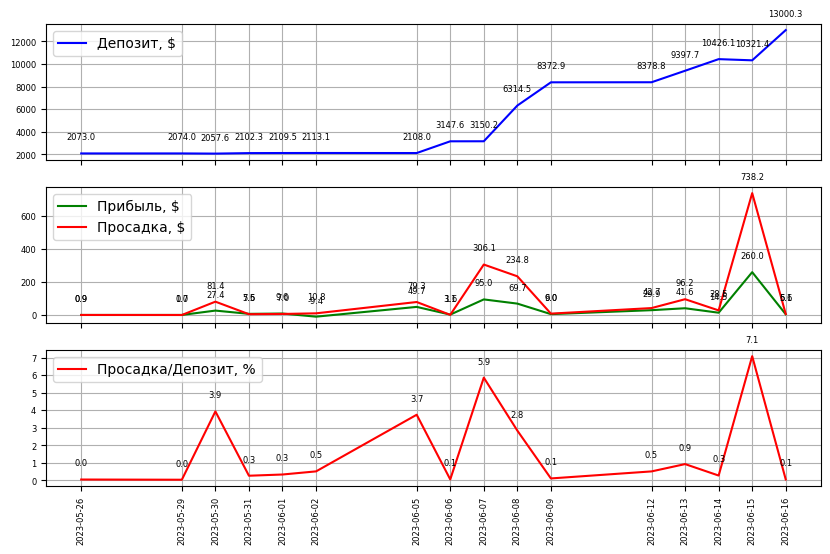

In [12]:
df_plot = df_o.copy()
df_plot['DT'] = df_plot['OPEN_DT'].dt.date
df_plot['DK_DRAWDOWN_RATIO'] = df_plot['DK_DRAWDOWN_RATIO'] * 100

df_plot = df_plot.groupby(by=['DT']).agg({
    'DK_DRAWDOWN': 'max',
    'DK_DRAWDOWN_RATIO': 'max',
    'PROFIT': 'sum',
    'DK_BALANCE_IN': 'min',
    }).reset_index()

df_plot

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10,6))

ax[0].plot(df_plot['DT'], df_plot['DK_BALANCE_IN'], 'b-')
ax[1].plot(df_plot['DT'], df_plot['PROFIT'], 'g',
           df_plot['DT'], df_plot['DK_DRAWDOWN'], 'r')
# ax01 = ax[0].twinx()

# ax[0].set_ylim(0)
# ax01.set_ylim(0, 12500)

ax[2].plot(df_plot['DT'], df_plot['DK_DRAWDOWN_RATIO'], 'r')
# plt.bar(df_plot['DT'], df_plot['Profit'])

for ax_i in ax:
    ax_i.grid()
    # ax[0].locator_params(axis='y', nbins=5)
    ax_i.tick_params(axis='both', which='major', labelsize=6)

# df_plot['DK_DRAWDOWN_RATIO']

    for line in ax_i.lines:
        
        for x,y in zip(df_plot['DT'], line.get_ydata()):
            label = "{:.1f}".format(y)

            ax_i.annotate(label, # this is the text
                        (x,y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,10), # distance from text to points (x,y)
                        ha='center', # horizontal alignment can be left, right or cente
                        fontsize=6,
                        ) 


plt.xticks(df_plot['DT'], rotation=90, fontsize=6)

ax[0].legend(['Депозит, $'])
ax[1].legend(['Прибыль, $', 'Просадка, $'])
ax[2].legend(['Просадка/Депозит, %'])




fig.show()


# 05. Worst Drawdown 20 Orders Grids

In [13]:
df_grids.sort_values(by='DK_DRAWDOWN_20_RATIO', ascending=False).head(10)

,DK_GRID_ID,OPEN_DT,CLOSE_DT,ORDER_ID,PROFIT,DK_GRID_OPEN_QTY,QTY,OPEN_PRICE,DK_GRID_LAST_PRICE,DK_OPEN_VALUE,DK_WORST_PRICE,DK_BALANCE_IN,DK_GRID_AVG_PRICE,DK_DRAWDOWN,DK_DRAWDOWN_RATIO,DK_DRAWDOWN_20,DK_DRAWDOWN_20_RATIO,DK_LOT_1000
370,72841443,2023-06-16 04:42:01,2023-06-16 09:07:44,3,1.1308,0.20,0.75,1960.58,1955.86,1468.4792,1954.07,13000.5540,1957.972267,2.9267,0.000225,16967.526268,1.305139,0.015384
288,72263225,2023-06-13 16:22:01,2023-06-13 16:38:15,4,1.4966,0.15,0.98,1957.61,1963.77,1922.2868,1965.56,10394.8613,1961.517143,3.9620,0.000381,13439.308898,1.292880,0.014430
309,72412004,2023-06-14 12:27:01,2023-06-14 15:30:02,4,2.2126,0.15,0.98,1952.47,1946.79,1909.8262,1945.00,10429.6443,1948.802245,3.7262,0.000357,13435.129098,1.288168,0.014382
325,72512152,2023-06-14 21:07:01,2023-06-14 21:24:06,4,1.5236,0.15,0.98,1940.08,1948.55,1906.3300,1950.34,10453.5905,1945.234694,5.0032,0.000479,13440.350098,1.285716,0.014349
327,72523610,2023-06-14 21:25:00,2023-06-14 22:14:50,4,1.4743,0.15,0.98,1944.57,1952.16,1910.6907,1953.95,10454.9039,1949.684388,4.1803,0.000400,13439.527198,1.285476,0.014347
343,72636236,2023-06-15 08:57:00,2023-06-15 12:18:15,4,1.5407,0.15,0.98,1938.99,1931.46,1895.3473,1929.67,10490.1040,1934.027857,4.2707,0.000407,13434.584598,1.280691,0.014299
346,72656122,2023-06-15 10:03:01,2023-06-15 14:19:47,4,1.5244,0.15,0.98,1929.85,1936.01,1895.1490,1937.80,10493.9926,1933.825510,3.8950,0.000371,13439.241898,1.280661,0.014294
271,72106833,2023-06-12 19:19:01,2023-06-13 05:02:25,4,1.3107,0.14,0.87,1954.06,1959.69,1703.1699,1961.48,9397.0988,1957.666552,3.3177,0.000353,11930.615456,1.269606,0.014898
277,72213447,2023-06-13 13:48:01,2023-06-13 15:29:48,4,1.4229,0.14,0.87,1965.49,1958.90,1706.3436,1957.11,9400.8086,1961.314483,3.6579,0.000389,11926.754456,1.268695,0.014892
341,72622159,2023-06-15 08:08:02,2023-06-15 09:19:47,5,2.4003,0.15,1.60,1932.13,1939.26,3099.2323,1941.05,10489.0238,1937.020188,6.4477,0.000615,13297.680816,1.267771,0.014301
